# TP Bayes

## Imports

In [44]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

## Dataset
* Load iris dataset.
* Using the function cut() and numpy.concatenate(), unbalance the dataset (keep 100% of class 0, 50% of class 1, 33% of class 2)
* Split in train/test.

In [45]:
def cut(X, y, c, step):
    return X[np.where(y[...]==c)][::step], y[y==c][::step]

In [46]:
dataset = datasets.load_iris()
X_0, y_0 = cut(dataset.data, dataset.target, 0, 1)
print(X_0.shape, y_0.shape)
# try first what the previous line is doing, what is going to happen when changing the value of step
X_1, y_1 = cut(dataset.data, dataset.target, 1, 2)  # 50%
print(X_1.shape, y_1.shape)

X_2, y_2 = cut(dataset.data, dataset.target, 2, 3)  # 33%
print(X_2.shape, y_2.shape)

X = np.concatenate((X_0, X_1, X_2), axis=0)
y = np.concatenate((y_0, y_1, y_2), axis=0)

(50, 4) (50,)
(25, 4) (25,)
(17, 4) (17,)


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Summarize data

### Separate data by class
Analyse the following functions to separate data by class.

What is the type of `class_data`? How to get the values for a given class?

`class_data` is a dictionary

In [48]:
def separateByClass(X, y):
    return {c: cut(X, y, c, 1)[0] for c in np.unique(y)}

class_data = separateByClass(X_train, y_train)
print(type(class_data))
print(class_data)

<class 'dict'>
{0: array([[4.8, 3.4, 1.6, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.9, 3.1, 1.5, 0.1],
       [5.1, 3.4, 1.5, 0.2],
       [5.3, 3.7, 1.5, 0.2],
       [5.1, 3.8, 1.6, 0.2],
       [4.6, 3.4, 1.4, 0.3],
       [5.7, 4.4, 1.5, 0.4],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.3],
       [5. , 3.2, 1.2, 0.2],
       [4.6, 3.2, 1.4, 0.2],
       [4.9, 3.6, 1.4, 0.1],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.5, 0.4],
       [5.1, 3.5, 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [5.1, 3.8, 1.9, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5. , 3.5, 1.3, 0.3],
       [5. , 3.5, 1.6, 0.6],
       [4.8, 3.4, 1.9, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [5.1, 3.5, 1.4, 0.3],
       [5.5, 3.5, 1.3, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.5, 2.3, 1.3, 0.3],
       [4.8, 3. , 1.4, 0

### Summarize dataset
For each classes, calculate the mean and the standard deviation for each features.
Store it in a structure like this:

    {
        class: [(mean 1st feature, std 1st feature), (mean 2nd feature, std 2nd feature), ...],
        class: [...],
        ...
    }

In [49]:
def summarize(X):
    return [(np.mean(X[:, i]), np.std(X[:, i])) for i in range(X.shape[1])]

def summarizeByClass(X, y):
    return {c: summarize(X[np.where(y==c)]) for c in np.unique(y)}

summary = summarizeByClass(X_train, y_train)
print(summary)

{0: [(4.985000000000001, 0.3045898882103607), (3.4150000000000005, 0.3940494892776794), (1.4774999999999998, 0.15888281845435648), (0.255, 0.11390785749894516)], 1: [(6.01, 0.5494542747126462), (2.74, 0.3484250278036869), (4.265, 0.5002749244165652), (1.3400000000000003, 0.2009975124224178)], 2: [(6.461538461538463, 0.7301616907744176), (3.0461538461538464, 0.33423939972923733), (5.561538461538461, 0.5942525512562451), (2.176923076923077, 0.23908108104492387)]}


## Prediction
To make a prediction, we need to calculate the probability that a given sample belong to each class, and select the class with the highest probability.

### Compute likelihoods
Use the formula of the Univariate Gaussian distribution presented in the slides, and create a function to estimate the probability.

In [50]:
import math
def computeProbability(x, mean, std):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-((x - mean) ** 2 / (2 * std ** 2)))

In [51]:
# Verify your probability function
x = 10
mean = 10
stdev = 1
probability = computeProbability(x, mean, stdev)
print(probability) # Should be 0.3989422804014327

0.3989422804014327


**Q1:** What other methods could you use to compute a probability estimation?

We could compute a probability estimation using an histogram estimator.

### Compute priors

In [52]:
def computePriors(y):
    return {c: len(y[y==c]) / len(y) for c in np.unique(y)}

priors = computePriors(y_train)
print(priors)

{0: 0.547945205479452, 1: 0.273972602739726, 2: 0.1780821917808219}


### Compute posteriors

In [53]:
def computePosteriors(sample, summaries):
    posteriors = {}
    for c in summaries:
        posteriors[c] = 1
        for i in range(len(summaries[c])):
            mean, std = summaries[c][i]
            x = sample[i]
            posteriors[c] *= computeProbability(x, mean, std)
    return posteriors

### Use posteriors to take decisions about best classes

In [54]:
def predictSample(sample, summaries):
    posteriors = computePosteriors(sample, summaries)
    best_class, best_prob = None, -1
    for c in posteriors:
        if best_class is None or posteriors[c] > best_prob:
            best_prob = posteriors[c]
            best_class = c
    return best_class

## Test
Compute the accuracy of your classifier applied to your test set.

In [55]:
def predict(X, summaries):
    return np.array([predictSample(sample, summaries) for sample in X])

y_pred = predict(X_test, summary)
print(accuracy_score(y_test, y_pred))

0.9473684210526315


### Optional: use cross-validation

In [56]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(GaussianNB(), X, y, cv=5)
print(scores)

[0.89473684 1.         0.94444444 0.94444444 1.        ]


### Use the scikit-learn Gaussian Naive Bayes implementation and compare the results

In [57]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9473684210526315


## Plot the distribution
For each class, and for each feature, plot the histogram of the data.

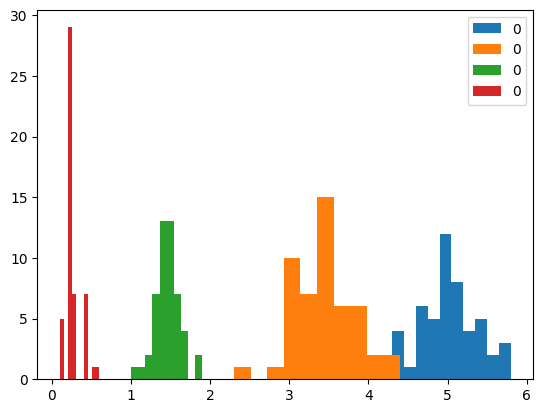

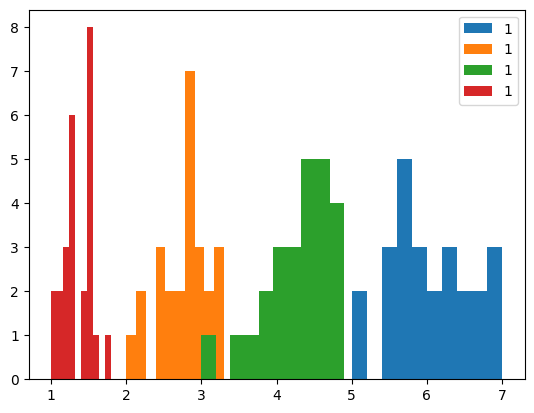

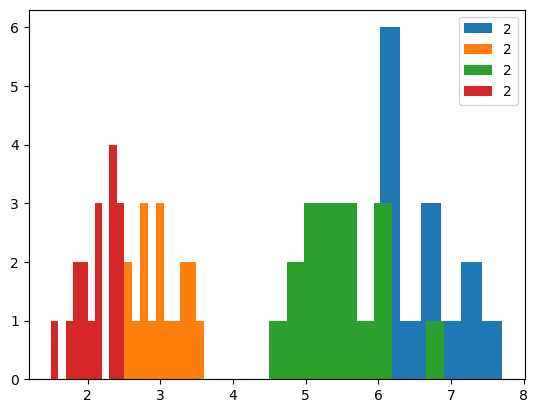

In [58]:
def plot_histograms(X, y):
    for c in np.unique(y):
        for i in range(X.shape[1]):
            plt.hist(X[np.where(y==c)][:, i], label=c)
        plt.legend()
        plt.show()

plot_histograms(X, y)

Based on the histograms, find which feature you think have the most Gaussian distribution.

Do the classification with only one feature (for each features).

Verify if the feature you chose is the one that gives you the best result.

In [59]:
def find_best_feature(X, y):
    best_feature = None
    best_score = -1
    for i in range(X.shape[1]):
        score = np.mean(np.abs(np.diff(np.sort(X[:, i]))))
        if score > best_score:
            best_score = score
            best_feature = i
    return best_feature

print(find_best_feature(X, y))

2


In [79]:
X_2 = X[:, 2].reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.2, random_state=42, stratify=y)

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9473684210526315


**Q2:** What happens if the distribution is not Gaussian at all? What would you do in this situation?

Les résultats globaux seront impactés car Bayes dépend directement de cette distribution. Pour améliorer les résultats en gardant ces données, nous pourrions les normalisées autours du point moyens.

## Optional: Use histograms as likelihood estimator

Try to replace the univariate gaussian with a solution based on histograms (see https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.histogram.html) in order to estimate the likelihood. Compare your results.


Conclusion and observations

Les features 3 et 4 sont celles qui donnent les meilleures résultats et la 3ème a la meilleure distribution gaussienne.
